## Imports and Config

In [1]:
import gymnasium as gym
import numpy as np
from scipy.special import softmax

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random
from collections import namedtuple, deque
import datetime

import matplotlib.pyplot as plt
from tqdm import tqdm

KeyboardInterrupt: 

In [ ]:
BUFFER_SIZE = 100000
BATCH_SIZE = 64
GAMMA = 0.99
LR = 0.0005
UPDATE_EVERY = 20

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Dueling DQN

- Dueling DQN is a variant of the DQN algorithm that separates the learning of the value and advantage functions. 

- This allows the agent to learn which states are valuable and in which states the actions really matter, without having to learn the effect of each action in each state. 

- This is particularly useful in environments where the effect of the action is independent of the state, or in states where the action has no effect.

### QNetwork

This contains the base QNetwork class. We implement 2 variants of DDQN:
1. `Type 1`: $$Q(s,a; \theta) = V(s;\theta) + (A(s,a;\theta) - \frac{1}{|A|} \sum_{a'} A(s,a';\theta))$$
2. `Type 2`: $$Q(s,a; \theta) = V(s;\theta) + (A(s,a;\theta) - \max_{a'} A(s,a';\theta))$$

In [ ]:
class QNetwork(nn.Module):

    def __init__(
        self,
        state_size: int,
        action_size: int,
        seed: int = 0,
        n_hidden_layers: int = 2,
        hidden_layer_size: int = 128,
    ):
        """Initialize parameters and build model."""
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.common_layers = nn.ModuleList(
            [nn.Linear(state_size, hidden_layer_size)]
            + [
                nn.Linear(hidden_layer_size, hidden_layer_size)
                for _ in range(n_hidden_layers)
            ]
        )
        self.value_layer = nn.Linear(hidden_layer_size, 1)
        self.advantage_layer = nn.Linear(hidden_layer_size, action_size)

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError

In [ ]:
class QNetwork_1(QNetwork):

    def __init__(
        self,
        state_size: int,
        action_size: int,
        seed: int = 0,
        n_hidden_layers: int = 2,
        hidden_layer_size: int = 128,
    ):
        """Initialize parameters and build model."""
        super(QNetwork_1, self).__init__(
            state_size, action_size, seed, n_hidden_layers, hidden_layer_size
        )

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Build a network that maps state -> action values."""

        x = state
        for layer in self.common_layers:
            x = F.relu(layer(x))
        value = self.value_layer(x)
        advantage = self.advantage_layer(x)
        action_values = value + advantage - advantage.mean()
        return action_values

In [ ]:
class QNetwork_2(QNetwork):

    def __init__(
        self,
        state_size: int,
        action_size: int,
        seed: int = 0,
        n_hidden_layers: int = 2,
        hidden_layer_size: int = 128,
    ):
        """Initialize parameters and build model."""
        super(QNetwork_2, self).__init__(
            state_size, action_size, seed, n_hidden_layers, hidden_layer_size
        )

    def forward(self, state: torch.Tensor) -> torch.Tensor:
        """Build a network that maps state -> action values."""

        x = state
        for layer in self.common_layers:
            x = F.relu(layer(x))
        value = self.value_layer(x)
        advantage = self.advantage_layer(x)
        action_values = value + advantage - advantage.max()
        return action_values

### Replay Buffer

- The Q-Network makes use of a replay buffer of size `BUFFER_SIZE` to store experience tuples. 

- The replay buffer is used to sample a batch of experiences to train the Q-Network.

In [ ]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object."""

        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## Agent

- The Agent class is a general learner that learns according to a given algorithm (`DDQN_Agent` learns according to the Dueling DQN algorithm).

- Every learner must have an `act` method that returns an action given a state, and a `learn` method that updates the Q-Network based on the experience tuple.

In [ ]:
class Agent:

    def step(
        self,
        state: np.ndarray,
        action: int,
        reward: float,
        next_state: np.ndarray,
        done: bool,
    ):
        raise NotImplementedError   

    def act(self, state: np.ndarray) -> int:
        raise NotImplementedError
    
    def learn(self, experiences: tuple, gamma: float =  GAMMA):
        raise NotImplementedError

## Exploration Policy

We provide 2 exploration policies:

1. `epsilonGreedyAction`: This is a simple exploration policy that selects a random action with probability `epsilon`, and the action with the highest Q-value otherwise.

2. `SoftmaxAction`: This is a more sophisticated exploration policy that selects actions according to the softmax of the Q-values.

In [ ]:
def epsilonGreedyAction(action_values, epsilon):
    if random.random() > epsilon:
        return np.argmax(action_values)
    else:
        return random.choice(len(action_values))
    
def SoftmaxAction(action_values, tau):
    probs = softmax(action_values / tau)
    return np.random.choice(len(action_values), p=probs)

### Dueling DQN Agent

In [ ]:
class DDQN_Agent(Agent):

    def __init__(
        self,
        state_size: int,
        action_size: int,
        seed: int = 0,
        type: int = 1,
        action_policy: callable = SoftmaxAction,
        n_hidden_layers: int = 2,
        hidden_layer_size: int = 128,
        learning_rate: float = LR,
    ):
        """Agent-Environment Interaction"""
        self.state_size = state_size
        self.action_size = action_size
        self.seed = seed
        random.seed(seed)
        self.type = type
        self.action_policy = action_policy
        self.n_hidden_layers = n_hidden_layers
        self.hidden_layer_size = hidden_layer_size
        self.learning_rate = learning_rate

        """ Q-Network """
        if type == 1:
            self.qnetwork_local = QNetwork_1(
                state_size, action_size, seed, n_hidden_layers, hidden_layer_size
            ).to(device)
            self.qnetwork_target = QNetwork_1(
                state_size, action_size, seed, n_hidden_layers, hidden_layer_size
            ).to(device)
        elif type == 2:
            self.qnetwork_local = QNetwork_2(
                state_size, action_size, seed, n_hidden_layers, hidden_layer_size
            ).to(device)
            self.qnetwork_target = QNetwork_2(
                state_size, action_size, seed, n_hidden_layers, hidden_layer_size
            ).to(device)
        else:
            raise ValueError("type must be either 1 or 2")

        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=learning_rate)

        """ Replay memory"""
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

        """ Initialize time step (for updating every UPDATE_EVERY steps) """
        self.t_step = 0

    def reset(self, seed: int = 0):
        
        self.seed = seed
        random.seed(seed)
        if self.type == 1:
            self.qnetwork_local = QNetwork_1(
                self.state_size, self.action_size, self.seed, self.n_hidden_layers, self.hidden_layer_size
            ).to(device)
            self.qnetwork_target = QNetwork_1(
                self.state_size, self.action_size, self.seed, self.n_hidden_layers, self.hidden_layer_size
            ).to(device)
        elif self.type == 2:
            self.qnetwork_local = QNetwork_2(
                self.state_size, self.action_size, self.seed, self.n_hidden_layers, self.hidden_layer_size
            ).to(device)
            self.qnetwork_target = QNetwork_2(
                self.state_size, self.action_size, self.seed, self.n_hidden_layers, self.hidden_layer_size
            ).to(device)
        else:
            raise ValueError("type must be either 1 or 2")

        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=self.learning_rate)
        self.memory = ReplayBuffer(self.action_size, BUFFER_SIZE, BATCH_SIZE, self.seed)
        self.t_step = 0

    def step(
        self,
        state: np.ndarray,
        action: int,
        reward: float,
        next_state: np.ndarray,
        done: bool,
    ):
        """Save experience in replay memory"""
        self.memory.add(state, action, reward, next_state, done)

        """ If enough samples are available in memory, get random subset and learn """
        if len(self.memory) >= BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

        """ Update the target network every UPDATE_EVERY steps """
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

    def act(self, state: np.ndarray, tau: float = 1.0) -> int:

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        """ Action Selection as per policy """
        action = self.action_policy(action_values.cpu().data.numpy().squeeze(), tau)
        return action

    def learn(self, experiences: namedtuple, gamma: float = GAMMA):
        """+E EXPERIENCE REPLAY PRESENT"""
        states, actions, rewards, next_states, dones = experiences

        """ Get max predicted Q values (for next states) from target model """
        Q_targets_next = (
            self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        )

        """ Compute Q targets for current states """
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        """ Get expected Q values from local model """
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        """ Compute loss """
        loss = F.mse_loss(Q_expected, Q_targets)

        """ Minimize the loss """
        self.optimizer.zero_grad()
        loss.backward()

        self.optimizer.step()

# Trainer

- The Trainer class is used to train an `agent` in a given environment `env`. 

- It has a `train` method, where the agent interacts with the environment and learns from the experiences. The exploration is controlled by the `epsilon` parameter, which initially favours exploration and moves towards exploitation as training progresses.

In [ ]:
class Trainer:

    def __init__(self, agent: Agent, env: gym.Env, threshold: float = 250.0):
        self.agent = agent
        self.env = env
        self.threshold = threshold
        self.scores_mean = []
        self.scores_std = []

    def train_single_run(
        self,
        seed: int = 0,
        n_episodes: int = 2000,
        max_t: int = 1000,
        tau_start: float = 1.0,
        tau_end: float = 0.01,
        tau_decay: float = 0.995,
        render: bool = False,
    ):

        self.agent.seed = random.seed(seed)
        scores_window = deque(maxlen=100)
        scores_list = []
        tau = tau_start

        for i_episode in range(1, n_episodes + 1):
            state, _ = self.env.reset()
            score = 0

            for t in range(max_t):
                action = self.agent.act(state, tau)
                if render:
                    self.env.render()
                next_state, reward, done, _, _ = self.env.step(action)
                self.agent.step(state, action, reward, next_state, done)
                state = next_state
                score += reward
                if done:
                    break

            scores_window.append(score)
            scores_list.append(score)

            tau = max(tau_end, tau_decay * tau)

            print(
                f"\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}",
                end="",
            )

            if i_episode % 100 == 0:
                print(
                    f"\rEpisode {i_episode}\tAverage Score: {np.mean(scores_window):.2f}"
                )
            if np.mean(scores_window) >= self.threshold:
                print(
                    f"\nEnvironment solved in {i_episode} episodes!\tAverage Score: {np.mean(scores_window):.2f}"
                )
                torch.save(self.agent.qnetwork_local.state_dict(), "checkpoint.pth")
                break

        return scores_list

    def train_multiple_runs(
        self,
        n_runs: int = 5,
        seed_arr: np.ndarray = [0, 1, 2, 3, 4],
        n_episodes: int = 2000,
        max_t: int = 1000,
        tau_start: float = 1.0,
        tau_end: float = 0.01,
        tau_decay: float = 0.995,
        render: bool = False,
    ):
        all_scores = []
        for i in range(n_runs):
            print(f"RUN {i+1}")
            self.agent.reset(seed_arr[i])

            print(f"Seed: {self.agent.seed}")
            print(f"Type: {self.agent.type}")
            print(f"Hidden Layers: {self.agent.n_hidden_layers}")
            print(f"Hidden Layer Size: {self.agent.hidden_layer_size}")
            print(f"Learning Rate: {self.agent.learning_rate}")

            begin_time = datetime.datetime.now()
            scores = self.train_single_run(
                seed_arr[i], n_episodes, max_t, tau_start, tau_end, tau_decay, render
            )
            end_time = datetime.datetime.now()
            print(f"Time taken: {end_time - begin_time}")
            print("*" * 50)
            print(np.mean(scores), np.max(scores), np.min(scores))
            all_scores.append(scores)

        max_episode = max([len(scores) for scores in all_scores])

        all_scores = [
            scores + [np.mean(scores[-10:])] * (max_episode - len(scores)) for scores in all_scores
        ]
        self.scores_mean = np.mean(all_scores, axis=0)
        self.scores_std = np.std(all_scores, axis=0)

    
    def render_run(self):
        state = self.env.reset()
        for t in range(1000):
            action = self.agent.act(state)
            self.env.render()
            state, reward, done, _ = self.env.step(action)
            if done:
                break

In [ ]:
N_RUNS = 3
seed_arr = sorted([int(np.random.randint(0, 1000)) for _ in range(N_RUNS)])
print(seed_arr)

def my_avg(scores, window=3):
    return np.array(
        [np.mean(scores[i : i + window]) for i in range(len(scores) - window)]
    )

window = 3

[166, 213, 366]


In [ ]:
! pip install gym[classic_control]

zsh:1: no matches found: gym[classic_control]


In [ ]:
# env = gym.make("CartPole-v1", render_mode="human")
# state_size = env.observation_space.shape[0]
# n_actions = env.action_space.n
# env.reset(seed=0)

# # render the environment 
# env.render()

# agent = DDQN_Agent(`
#     state_size=state_size,
#     action_size=n_actions,
#     seed=0,
#     type=1,
#     n_hidden_layers=2,
#     hidden_layer_size=128,
#     learning_rate=0.0005,
# )

# trainer = Trainer(agent, env, threshold=475.0)
# trainer.train_multiple_runs(n_runs=N_RUNS, seed_arr=seed_arr, n_episodes=2000, render=True)`

In [ ]:
hidden_layer_size_params = [128]
n_hidden_layers_params = [0,1,2,3]
learning_rate_params = [0.001]
CUTOFF = 400

plt.figure(figsize=(10, 6))

# make a list of all the combinations of hyperparameters
param_list = [
    (hidden_layer_size, n_hidden_layers, learning_rate)
    for hidden_layer_size in hidden_layer_size_params
    for n_hidden_layers in n_hidden_layers_params
    for learning_rate in learning_rate_params
]

trainer_list = []
for hidden_layer_size, n_hidden_layers, learning_rate in tqdm(param_list):

    env = gym.make("CartPole-v1")
    state_shape = env.observation_space.shape[0]
    n_actions = env.action_space.n
    env.reset(seed=0)

    agent = DDQN_Agent(
        state_shape,
        n_actions,
        type=1,
        action_policy=SoftmaxAction,
        hidden_layer_size=hidden_layer_size,
        n_hidden_layers=n_hidden_layers,
        learning_rate=learning_rate,
    )
    trainer = Trainer(agent, env)
    trainer.train_multiple_runs(n_runs=N_RUNS, seed_arr=seed_arr)

    if len(trainer.scores_mean) > CUTOFF:
        print("################ CONFIG TOOK TOO LONG ################")
        trainer.scores_mean = trainer.scores_mean[:CUTOFF]
        trainer.scores_std = trainer.scores_std[:CUTOFF]

    # plt.plot(
    #     trainer.scores_mean,
    #     label=f"ls: {hidden_layer_size}, nl: {n_hidden_layers}, lr: {learning_rate}",
    # )
    plt.plot(
        trainer.scores_mean,
        label=f"{n_hidden_layers} hidden layer(s)",
    )
    
    plt.fill_between(
        range(len(trainer.scores_mean)),
        trainer.scores_mean - trainer.scores_std,
        trainer.scores_mean + trainer.scores_std,
        alpha=0.2,
    )
    trainer_list.append(trainer)

plt.title("Score vs Episodes")
plt.legend()
plt.show()

  0%|          | 0/4 [00:00<?, ?it/s]

RUN 1
Seed: 166
Type: 1
Hidden Layers: 0
Hidden Layer Size: 128
Learning Rate: 0.001
Episode 70	Average Score: 300.76
Environment solved in 70 episodes!	Average Score: 300.76
Time taken: 0:00:56.331706
**************************************************
300.75714285714287 1000.0 10.0
RUN 2
Seed: 213
Type: 1
Hidden Layers: 0
Hidden Layer Size: 128
Learning Rate: 0.001
Episode 100	Average Score: 213.86
Episode 123	Average Score: 300.93
Environment solved in 123 episodes!	Average Score: 300.93
Time taken: 0:01:18.918117
**************************************************
248.14634146341464 1000.0 9.0
RUN 3
Seed: 366
Type: 1
Hidden Layers: 0
Hidden Layer Size: 128
Learning Rate: 0.001
Episode 100	Average Score: 88.29
Episode 200	Average Score: 251.01
Episode 231	Average Score: 252.56

  0%|          | 0/4 [04:05<?, ?it/s]


KeyboardInterrupt: 

<Figure size 1000x600 with 0 Axes>

  0%|          | 0/4 [00:00<?, ?it/s]

RUN 1
Seed: 533
Type: 1
Hidden Layers: 2
Hidden Layer Size: 32
Learning Rate: 0.001
Episode 100	Average Score: 222.68
Episode 200	Average Score: 260.09
Episode 268	Average Score: 306.53
Environment solved in 268 episodes!	Average Score: 306.53
Time taken: 0:03:24.298749
**************************************************
262.82835820895525 1000.0 11.0
RUN 2
Seed: 702
Type: 1
Hidden Layers: 2
Hidden Layer Size: 32
Learning Rate: 0.001
Episode 100	Average Score: 148.85
Episode 200	Average Score: 202.78
Episode 276	Average Score: 305.85
Environment solved in 276 episodes!	Average Score: 305.85
Time taken: 0:03:03.529249
**************************************************
221.4673913043478 1000.0 12.0
RUN 3
Seed: 835
Type: 1
Hidden Layers: 2
Hidden Layer Size: 32
Learning Rate: 0.001
Episode 100	Average Score: 140.99
Episode 151	Average Score: 295.02

 25%|██▌       | 1/4 [08:12<24:36, 492.21s/it]

Episode 152	Average Score: 303.14
Environment solved in 152 episodes!	Average Score: 303.14
Time taken: 0:01:44.353048
**************************************************
231.7171052631579 1000.0 9.0
RUN 1
Seed: 533
Type: 1
Hidden Layers: 2
Hidden Layer Size: 64
Learning Rate: 0.001
Episode 100	Average Score: 257.31
Episode 200	Average Score: 189.35
Episode 300	Average Score: 120.28
Episode 400	Average Score: 56.803
Episode 500	Average Score: 53.14
Episode 600	Average Score: 42.42
Episode 700	Average Score: 96.929
Episode 800	Average Score: 45.22
Episode 900	Average Score: 50.66
Episode 1000	Average Score: 57.05
Episode 1100	Average Score: 16.56
Episode 1200	Average Score: 25.54
Episode 1300	Average Score: 17.59
Episode 1400	Average Score: 47.20
Episode 1500	Average Score: 13.78
Episode 1600	Average Score: 48.87
Episode 1700	Average Score: 12.49
Episode 1800	Average Score: 20.18
Episode 1900	Average Score: 10.08
Episode 2000	Average Score: 10.30
Time taken: 0:05:52.699811
**************

 50%|█████     | 2/4 [17:00<17:06, 513.28s/it]

Episode 113	Average Score: 301.20
Environment solved in 113 episodes!	Average Score: 301.20
Time taken: 0:01:27.146762
**************************************************
269.070796460177 1000.0 13.0
################ CONFIG TOOK TOO LONG ################
RUN 1
Seed: 533
Type: 1
Hidden Layers: 2
Hidden Layer Size: 128
Learning Rate: 0.001
Episode 74	Average Score: 301.31
Environment solved in 74 episodes!	Average Score: 301.31
Time taken: 0:01:06.664176
**************************************************
301.31081081081084 1000.0 10.0
RUN 2
Seed: 702
Type: 1
Hidden Layers: 2
Hidden Layer Size: 128
Learning Rate: 0.001
Episode 100	Average Score: 196.49
Episode 122	Average Score: 305.24
Environment solved in 122 episodes!	Average Score: 305.24
Time taken: 0:01:26.022101
**************************************************
258.23770491803276 1000.0 10.0
RUN 3
Seed: 835
Type: 1
Hidden Layers: 2
Hidden Layer Size: 128
Learning Rate: 0.001
Episode 100	Average Score: 177.41
Episode 141	Average Sco

 75%|███████▌  | 3/4 [21:14<06:35, 395.08s/it]

Episode 142	Average Score: 301.75
Environment solved in 142 episodes!	Average Score: 301.75
Time taken: 0:01:41.726978
**************************************************
251.03521126760563 1000.0 10.0
RUN 1
Seed: 533
Type: 1
Hidden Layers: 2
Hidden Layer Size: 256
Learning Rate: 0.001
Episode 48	Average Score: 311.62
Environment solved in 48 episodes!	Average Score: 311.62
Time taken: 0:00:46.297929
**************************************************
311.625 1000.0 12.0
RUN 2
Seed: 702
Type: 1
Hidden Layers: 2
Hidden Layer Size: 256
Learning Rate: 0.001
Episode 47	Average Score: 303.36
Environment solved in 47 episodes!	Average Score: 303.36
Time taken: 0:00:43.504765
**************************************************
303.36170212765956 1000.0 12.0
RUN 3
Seed: 835
Type: 1
Hidden Layers: 2
Hidden Layer Size: 256
Learning Rate: 0.001
Episode 56	Average Score: 292.41

100%|██████████| 4/4 [23:38<00:00, 354.66s/it]

Episode 57	Average Score: 304.82
Environment solved in 57 episodes!	Average Score: 304.82
Time taken: 0:00:54.136194
**************************************************
304.82456140350877 1000.0 10.0


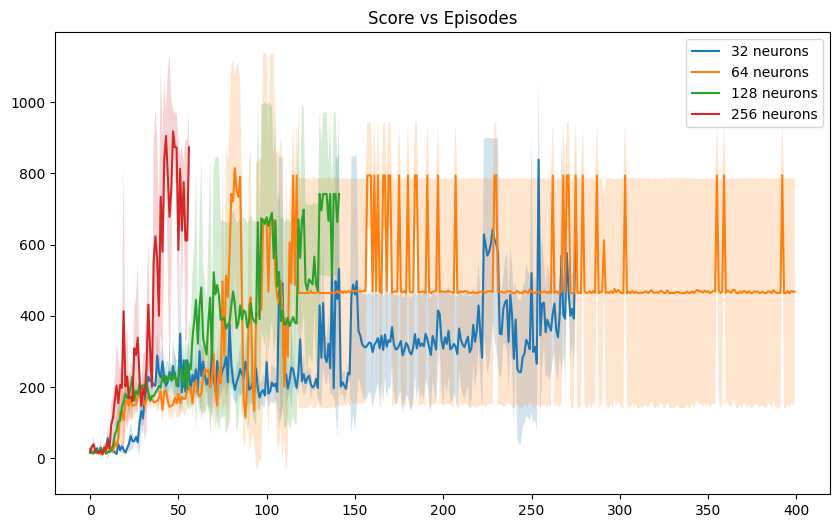

In [ ]:
hidden_layer_size_params = [32, 64, 128, 256]
n_hidden_layers_params = [2]
learning_rate_params = [0.001]
CUTOFF = 400

plt.figure(figsize=(10, 6))

# make a list of all the combinations of hyperparameters
param_list = [
    (hidden_layer_size, n_hidden_layers, learning_rate)
    for hidden_layer_size in hidden_layer_size_params
    for n_hidden_layers in n_hidden_layers_params
    for learning_rate in learning_rate_params
]

trainer_list_2 = []
for hidden_layer_size, n_hidden_layers, learning_rate in tqdm(param_list):

    env = gym.make("CartPole-v1")
    state_shape = env.observation_space.shape[0]
    n_actions = env.action_space.n
    env.reset(seed=0)

    agent = DDQN_Agent(
        state_shape,
        n_actions,
        type=1,
        action_policy=SoftmaxAction,
        hidden_layer_size=hidden_layer_size,
        n_hidden_layers=n_hidden_layers,
        learning_rate=learning_rate,
    )
    trainer = Trainer(agent, env)
    trainer.train_multiple_runs(n_runs=N_RUNS, seed_arr=seed_arr)

    if len(trainer.scores_mean) > CUTOFF:
        print("################ CONFIG TOOK TOO LONG ################")
        trainer.scores_mean = trainer.scores_mean[:CUTOFF]
        trainer.scores_std = trainer.scores_std[:CUTOFF]

    # plt.plot(
    #     trainer.scores_mean,
    #     label=f"ls: {hidden_layer_size}, nl: {n_hidden_layers}, lr: {learning_rate}",
    # )
    plt.plot(
        trainer.scores_mean,
        label=f"{hidden_layer_size} neurons"
    )
    
    plt.fill_between(
        range(len(trainer.scores_mean)),
        trainer.scores_mean - trainer.scores_std,
        trainer.scores_mean + trainer.scores_std,
        alpha=0.2,
    )
    trainer_list_2.append(trainer)

plt.title("Score vs Episodes")
plt.legend()
plt.show()

  0%|          | 0/5 [00:00<?, ?it/s]

RUN 1
Seed: 533
Type: 1
Hidden Layers: 2
Hidden Layer Size: 128
Learning Rate: 0.01
Episode 53	Average Score: 310.94
Environment solved in 53 episodes!	Average Score: 310.94
Time taken: 0:00:48.376178
**************************************************
310.9433962264151 1000.0 11.0
RUN 2
Seed: 702
Type: 1
Hidden Layers: 2
Hidden Layer Size: 128
Learning Rate: 0.01
Episode 93	Average Score: 300.17
Environment solved in 93 episodes!	Average Score: 300.17
Time taken: 0:01:16.980539
**************************************************
300.1720430107527 1000.0 15.0
RUN 3
Seed: 835
Type: 1
Hidden Layers: 2
Hidden Layer Size: 128
Learning Rate: 0.01
Episode 85	Average Score: 299.86

 20%|██        | 1/5 [03:19<13:18, 199.58s/it]

Episode 86	Average Score: 300.84
Environment solved in 86 episodes!	Average Score: 300.84
Time taken: 0:01:14.203270
**************************************************
300.83720930232556 1000.0 14.0
RUN 1
Seed: 533
Type: 1
Hidden Layers: 2
Hidden Layer Size: 128
Learning Rate: 0.005
Episode 97	Average Score: 300.55
Environment solved in 97 episodes!	Average Score: 300.55
Time taken: 0:01:24.157560
**************************************************
300.54639175257734 1000.0 13.0
RUN 2
Seed: 702
Type: 1
Hidden Layers: 2
Hidden Layer Size: 128
Learning Rate: 0.005
Episode 61	Average Score: 303.10
Environment solved in 61 episodes!	Average Score: 303.10
Time taken: 0:00:51.423268
**************************************************
303.0983606557377 1000.0 9.0
RUN 3
Seed: 835
Type: 1
Hidden Layers: 2
Hidden Layer Size: 128
Learning Rate: 0.005
Episode 100	Average Score: 232.35
Episode 107	Average Score: 292.54

 40%|████      | 2/5 [07:03<10:42, 214.11s/it]

Episode 108	Average Score: 302.40
Environment solved in 108 episodes!	Average Score: 302.40
Time taken: 0:01:28.683182
**************************************************
281.69444444444446 1000.0 11.0
RUN 1
Seed: 533
Type: 1
Hidden Layers: 2
Hidden Layer Size: 128
Learning Rate: 0.001
Episode 47	Average Score: 306.91
Environment solved in 47 episodes!	Average Score: 306.91
Time taken: 0:00:40.557755
**************************************************
306.9148936170213 1000.0 10.0
RUN 2
Seed: 702
Type: 1
Hidden Layers: 2
Hidden Layer Size: 128
Learning Rate: 0.001
Episode 93	Average Score: 301.18
Environment solved in 93 episodes!	Average Score: 301.18
Time taken: 0:01:24.403282
**************************************************
301.18279569892474 1000.0 12.0
RUN 3
Seed: 835
Type: 1
Hidden Layers: 2
Hidden Layer Size: 128
Learning Rate: 0.001
Episode 100	Average Score: 199.81
Episode 119	Average Score: 296.68

 60%|██████    | 3/5 [10:42<07:12, 216.36s/it]

Episode 120	Average Score: 304.67
Environment solved in 120 episodes!	Average Score: 304.67
Time taken: 0:01:34.051524
**************************************************
264.275 1000.0 10.0
RUN 1
Seed: 533
Type: 1
Hidden Layers: 2
Hidden Layer Size: 128
Learning Rate: 0.0005
Episode 100	Average Score: 186.38
Episode 155	Average Score: 304.82
Environment solved in 155 episodes!	Average Score: 304.82
Time taken: 0:01:52.526329
**************************************************
253.46451612903226 1000.0 9.0
RUN 2
Seed: 702
Type: 1
Hidden Layers: 2
Hidden Layer Size: 128
Learning Rate: 0.0005
Episode 100	Average Score: 245.10
Episode 107	Average Score: 300.34
Environment solved in 107 episodes!	Average Score: 300.34
Time taken: 0:01:29.066063
**************************************************
282.2616822429907 1000.0 11.0
RUN 3
Seed: 835
Type: 1
Hidden Layers: 2
Hidden Layer Size: 128
Learning Rate: 0.0005
Episode 100	Average Score: 178.95
Episode 193	Average Score: 292.33

 80%|████████  | 4/5 [16:19<04:23, 263.68s/it]

Episode 194	Average Score: 300.53
Environment solved in 194 episodes!	Average Score: 300.53
Time taken: 0:02:14.622731
**************************************************
241.6701030927835 1000.0 12.0
RUN 1
Seed: 533
Type: 1
Hidden Layers: 2
Hidden Layer Size: 128
Learning Rate: 0.0001
Episode 100	Average Score: 144.63
Episode 200	Average Score: 221.31
Episode 300	Average Score: 265.29
Episode 400	Average Score: 200.29
Episode 451	Average Score: 303.12
Environment solved in 451 episodes!	Average Score: 303.12
Time taken: 0:05:06.312036
**************************************************
230.56762749445676 1000.0 10.0
RUN 2
Seed: 702
Type: 1
Hidden Layers: 2
Hidden Layer Size: 128
Learning Rate: 0.0001
Episode 100	Average Score: 166.18
Episode 200	Average Score: 246.18
Episode 300	Average Score: 241.00
Episode 400	Average Score: 242.84
Episode 500	Average Score: 241.29
Episode 600	Average Score: 253.40
Episode 700	Average Score: 264.14
Episode 800	Average Score: 250.08
Episode 900	Average

100%|██████████| 5/5 [35:21<00:00, 424.38s/it]

Episode 213	Average Score: 300.19
Environment solved in 213 episodes!	Average Score: 300.19
Time taken: 0:02:08.570040
**************************************************
210.59154929577466 554.0 9.0
################ CONFIG TOOK TOO LONG ################


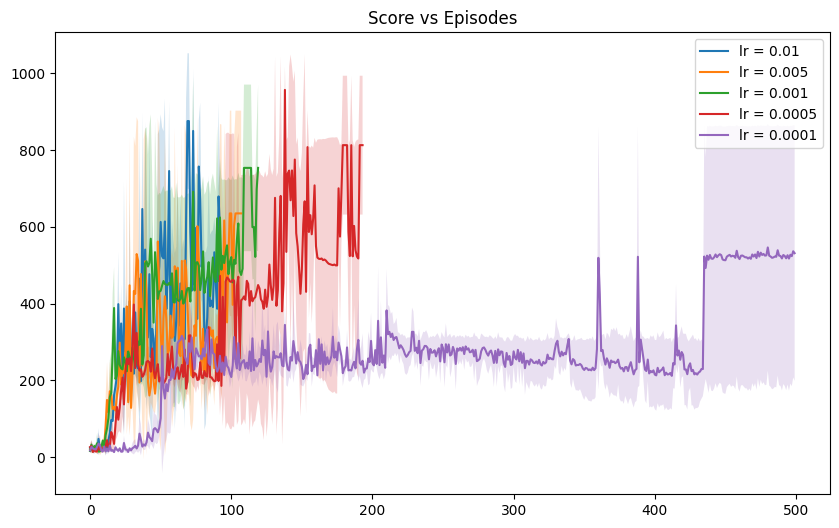

In [ ]:
hidden_layer_size_params = [128]
n_hidden_layers_params = [2]
learning_rate_params = [0.01, 0.005, 0.001, 0.0005, 0.0001]
CUTOFF = 500

plt.figure(figsize=(10, 6))

# make a list of all the combinations of hyperparameters
param_list = [
    (hidden_layer_size, n_hidden_layers, learning_rate)
    for hidden_layer_size in hidden_layer_size_params
    for n_hidden_layers in n_hidden_layers_params
    for learning_rate in learning_rate_params
]

trainer_list_3 = []
for hidden_layer_size, n_hidden_layers, learning_rate in tqdm(param_list):

    env = gym.make("CartPole-v1")
    state_shape = env.observation_space.shape[0]
    n_actions = env.action_space.n
    env.reset(seed=0)

    agent = DDQN_Agent(
        state_shape,
        n_actions,
        type=1,
        action_policy=SoftmaxAction,
        hidden_layer_size=hidden_layer_size,
        n_hidden_layers=n_hidden_layers,
        learning_rate=learning_rate,
    )
    trainer = Trainer(agent, env)
    trainer.train_multiple_runs(n_runs=N_RUNS, seed_arr=seed_arr)

    if len(trainer.scores_mean) > CUTOFF:
        print("################ CONFIG TOOK TOO LONG ################")
        trainer.scores_mean = trainer.scores_mean[:CUTOFF]
        trainer.scores_std = trainer.scores_std[:CUTOFF]

    # plt.plot(
    #     trainer.scores_mean,
    #     label=f"ls: {hidden_layer_size}, nl: {n_hidden_layers}, lr: {learning_rate}",
    # )
    plt.plot(
        trainer.scores_mean,
        label=f"lr = {learning_rate}"
    )
    
    plt.fill_between(
        range(len(trainer.scores_mean)),
        trainer.scores_mean - trainer.scores_std,
        trainer.scores_mean + trainer.scores_std,
        alpha=0.2,
    )
    trainer_list_3.append(trainer)

plt.title("Score vs Episodes")
plt.legend()
plt.show()

In [ ]:
# plt.figure(figsize=(10, 6))
# plt.plot(trainer_1.scores_mean, label="Type 1", color="red")
# plt.fill_between(
#     range(len(trainer_1.scores_mean)),
#     trainer_1.scores_mean + trainer_1.scores_std,
#     trainer_1.scores_mean - trainer_1.scores_std,
#     alpha=0.2,
#     color="red",
# )
# plt.plot(trainer_2.scores_mean, label="Type 2", color="blue")
# plt.fill_between(
#     range(len(trainer_2.scores_mean)),
#     trainer_2.scores_mean + trainer_2.scores_std,
#     trainer_2.scores_mean - trainer_2.scores_std,
#     alpha=0.2,
#     color="blue",
# )
# plt.legend()
# plt.xlabel("Episode Number")
# plt.ylabel("Episode Return")
# plt.title("Dueling-DQN (CartPole_v1)")
# plt.show()

In [ ]:
# plt.figure(figsize=(10, 6))
# plt.plot(my_avg(trainer_1.scores_mean, window=window), label="Type 1", color="red")
# plt.fill_between(
#     range(len(trainer_1.scores_mean) - window),
#     my_avg(trainer_1.scores_mean, window=window) + my_avg(trainer_1.scores_std, window=window),
#     my_avg(trainer_1.scores_mean, window=window) - my_avg(trainer_1.scores_std, window=window),
#     alpha=0.2,
#     color="red",
# )
# plt.plot(my_avg(trainer_2.scores_mean, window=window), label="Type 2", color="blue")
# plt.fill_between(
#     range(len(trainer_2.scores_mean) - window),
#     my_avg(trainer_2.scores_mean, window=window) + my_avg(trainer_2.scores_std, window=window),
#     my_avg(trainer_2.scores_mean, window=window) - my_avg(trainer_2.scores_std, window=window),
#     alpha=0.2,
#     color="blue",
# )
# plt.legend()
# plt.xlabel("Episode Number")
# plt.ylabel("Episode Return")
# plt.title("Dueling-DQN (CartPole_v1)")
# plt.show()